### Data References and Introduction

<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

#### Load Dataset

In [9]:
#  import relevant libraries to display data

import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

#### Display Sample Data

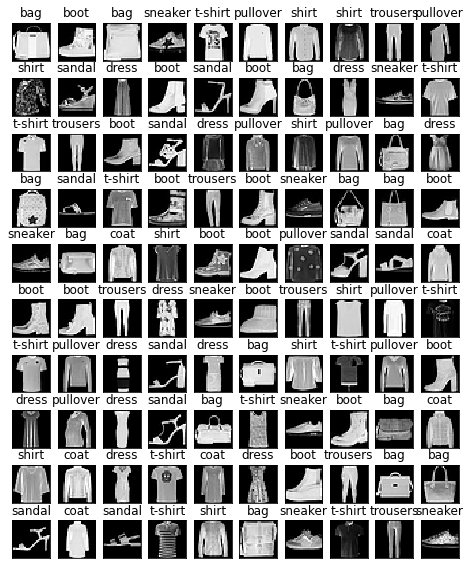

In [10]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 10  #  number of rows and columns produced
st_idx = R.randint(0, train_images.shape[0]-N*N-1)

for i in range(N * N):
    plt.subplot(N, N, i+1)
    plt.imshow(train_images[st_idx + i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx + i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Autoencoder

#### Set-up

Import relevant libraries in keras

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Input
from tensorflow.keras import Model

Flatten each image of both the training and test array to (784, 1) array

In [12]:
# number of images
Ntr = train_images.shape[0]
Nts = test_images.shape[0]

# image shape
szx = train_images.shape[1]  # pixels in x direction
szy = train_images.shape[2]  # pixels in y direction

# need to reshape the 28x28 training/testing images as vectors
train_images_vec = train_images.reshape((Ntr, szx * szy))
test_images_vec = test_images.reshape(  (Nts, szx * szy))

# deciding to normalize the pixels to 0..1 and recase as float32
# making pixels decimals between 0 and 1
train_images_vec = train_images_vec.astype('float32') / 255.0
test_images_vec = test_images_vec.astype('float32') / 255.0

#  used for classification problem later
train_labels_class = to_categorical(train_labels)
test_labels_class = to_categorical(test_labels)

# display new input dimensions/type to verify
print('Dimensionality Verification:\n')
print('Original train shape', train_images.shape)
print('New train shape:', train_images_vec.shape, '\n')
print('Original test shape', test_images.shape)
print('New test shape:', test_images_vec.shape)

Dimensionality Verification:

Original train shape (60000, 28, 28)
New train shape: (60000, 784) 

Original test shape (10000, 28, 28)
New test shape: (10000, 784)


We will only be training the autoencoder on half of the training set, which will be 30,000 total training images.

In [13]:
autoencoder_train = train_images_vec[0: int((train_images_vec.shape[0]) / 2)]  #  for autoencoder training
rdr_train = train_images_vec[int((train_images_vec.shape[0]) / 2) : int(train_images_vec.shape[0])]

#### Autoassociator Function Creation

Created a function, allowing for the network to be tested with varying hidden units in the single hidden layer.

In [14]:
def auto_funct(latent_dim, train_epochs, train_pats, train_labels, flabels, size):

  nin = size * size  # avoid hardcoding, put this in as a keyword in the function
  nout = nin  # verify dimensionality

  #  create a singular hidden layer, using a linear activation to properly model PCA
  autoencoder = models.Sequential()
  autoencoder.add(layers.Dense(latent_dim, 
                         activation='linear', 
                         input_shape=(nin,)))
  autoencoder.add(layers.Dense(nin,
                      activation = 'linear')) 

  #  print layer summary to verify dimensionality during testing
  print(autoencoder.summary())
  print()
  for layer in autoencoder.layers:
      print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
  print()
  for layer in autoencoder.layers:
      print(layer.get_config())
  print()

  #  define an optimizer for use during compiling, use adam
  #  throughout research and resources provided, adam is the optimal optimizers for computer vision in many cases
  adam = optimizers.Adam(learning_rate = 0.001)

  #  compile the network
  autoencoder.compile(optimizer = adam,
                      loss = 'mean_squared_error',
                      metrics = ['accuracy', 'mse'])
  
  #  train the network
  history = autoencoder.fit(train_pats,
                train_pats,
                epochs = train_epochs,
                batch_size = 256,
                verbose = False,
                validation_split = 0.1)
  
  #  create patterns for visualization
  #  predict on the same patterns as the input and output of the network (this is the definition of an autoencoder)
  out = autoencoder.predict(train_pats)

  #  create a subplot to visualize performance
  n = 10  #  number of images
  plt.figure(figsize = (20, 4))

  for i in range(n):
    original = plt.subplot(2, n, i +1)
    label = flabels[train_labels[i]]

    plt.imshow(train_images[i].reshape(szx, szy), cmap = 'gray', interpolation = None)
    plt.title('Original: ' + label)
    plt.xticks([])
    plt.yticks([])

    predicted = plt.subplot(2, n, i+1+n)
    plt.title('Predicted: ' + label)
    plt.imshow(out[i].reshape(szx, szy), cmap = 'gray', interpolation = None)
    plt.xticks([])
    plt.yticks([])

  return autoencoder, history, layers

In [15]:
#  create a function to create an accuracy graph, since it used for various networks in this PA

def accuracy_graph(network):
  epoch_list = np.arange(0, network[1].params['epochs'])  # creates an array of x values for each epoch
  accuracy_list = network[1].history['accuracy']  # calls the accuracies from training the network above

  #  Plot the data
  plt.plot(epoch_list, accuracy_list)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')


#  create a function for loss and val_loss as well

def loss_graph(network):
  # create epochs vs. val_loss + loss graph
  epoch_list = np.arange(0, network[1].params['epochs'])
  
  loss_list = network[1].history['loss']
  val_loss_list = network[1].history['val_loss']

  plt.plot(epoch_list, loss_list, 'r', val_loss_list, 'c')
  plt.legend(('loss', 'val_loss'), loc='center right')
  plt.xlabel('Epochs')
  plt.title('Model Accuracy')

#### Good Autoencoder Example

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 175)               137375    
                                                                 
 dense_1 (Dense)             (None, 784)               137984    
                                                                 
Total params: 275,359
Trainable params: 275,359
Non-trainable params: 0
_________________________________________________________________
None

layer name : dense | input shape : (None, 784) | output shape : (None, 175)
layer name : dense_1 | input shape : (None, 175) | output shape : (None, 784)

{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 784), 'dtype': 'float32', 'units': 175, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config

2022-11-20 21:16:26.949530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 21:16:26.949840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-20 21:16:27.195347: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 21:16:27.374467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:16:28.077078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/938 [==>...........................] - ETA: 1s

2022-11-20 21:16:40.318242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 1s 1ms/step


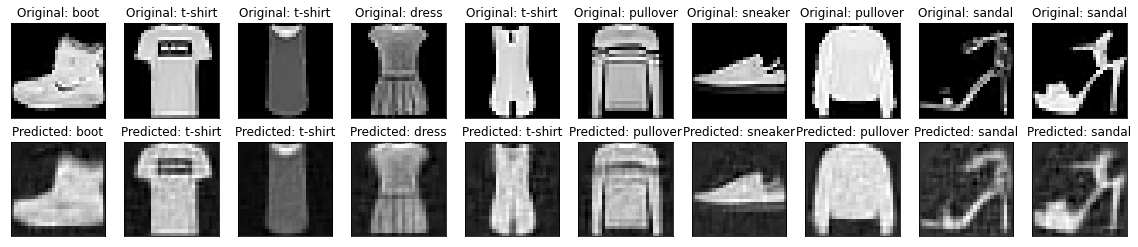

In [16]:
nhid = 175
train_epochs = 25  # hard code this value for use throughout autoassociation testing

 # use autoencoder_train, which is only half of the training images
auto175 = auto_funct(nhid, train_epochs, autoencoder_train, train_labels, flabels, szx)

##### Good Autoencoder Graphs

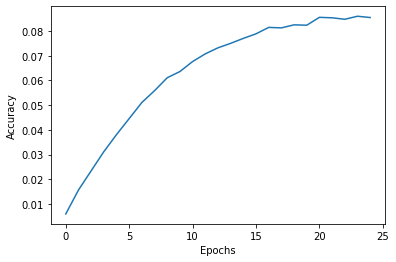

In [17]:
accuracy_graph(auto175)

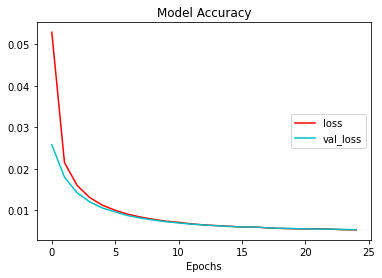

In [18]:
loss_graph(auto175)

This graph show no sign of overfitting. Validation loss and loss do not diverge at any point.

##### Architecture Analysis

I settled on 125 hidden units (latent dimensions) after trying out too few and too many hidden units. Here was my process on settling for 125 units:

I first started with 20 hidden units. This many units made it difficult to distinguish between different clothing items. For example, it was hard to tell a dress from a shirt in the predicted images. Additionally, the accuracy graph never hit a horizontal asymptote. Logically, I increased the number of hidden units.

I then decided to take it the other extreme with 300 hidden units. This took almost a minute to run, but it did a good job of remaking the images. I figured I would reduced the number of hidden units to reduce runtime and find a "happy medium" between runtime and accuracy of the network.

175 units worked well. The network only took 30 seconds to train and produced adequate images. The accuracy and loss graphs both proved sufficient as well, as they demonstrated behavior of a well trained model. There was no evidence of overfitting either, as validation loss and training loss did not diverge

#### Bad Autoencoder Example

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 3925      
                                                                 
 dense_3 (Dense)             (None, 784)               4704      
                                                                 
Total params: 8,629
Trainable params: 8,629
Non-trainable params: 0
_________________________________________________________________
None

layer name : dense_2 | input shape : (None, 784) | output shape : (None, 5)
layer name : dense_3 | input shape : (None, 5) | output shape : (None, 784)

{'name': 'dense_2', 'trainable': True, 'batch_input_shape': (None, 784), 'dtype': 'float32', 'units': 5, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'k

2022-11-20 21:16:42.563490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:16:43.163130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


118/938 [==>...........................] - ETA: 1s

2022-11-20 21:16:55.172129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 1s 1ms/step


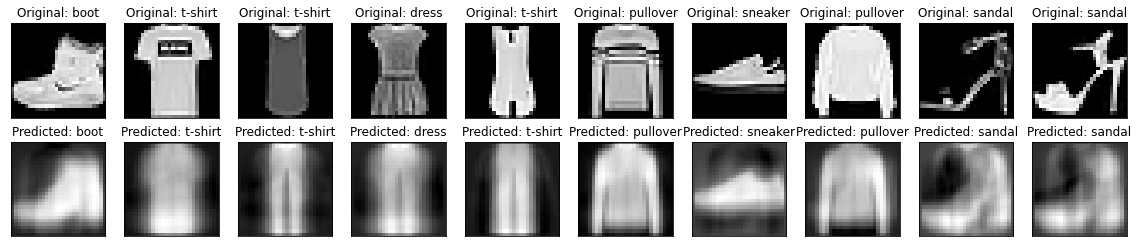

In [19]:
nhid = 5  #  reduced number of hidden units to extreme to demonstrate what the hidden layers are doing

auto5 = auto_funct(nhid, train_epochs, autoencoder_train, train_labels, flabels, szx)

Too few hidden units (ten in this case) produces an extremely blurry recreated image as expected.

##### Bad Autoassociator Graphs

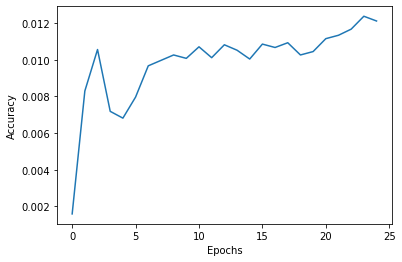

In [20]:
accuracy_graph(auto5)

Notice the jagged accuracy graph. This is not characteristic behavior of a sufficient model.

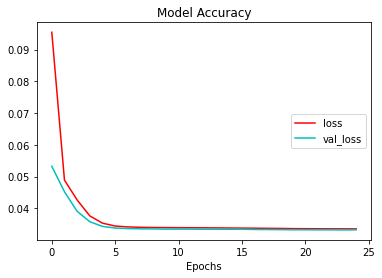

In [21]:
loss_graph(auto5)

This graph show no sign of overfitting. Validation loss and loss do not diverge at any point.

### Image Classification (multi-layered)

#### Creation of Reduced-Dimensionality Training Patterns for Classification

In [22]:
autoencoder = auto175[0]  # pull the data from the auto125 network, which was the good autoassociator. need an indice because of the functionxx

autoencoder_weights = autoencoder.layers[0].get_weights()[0]  #  weights from the autoencoder network
autoencoder_bias = autoencoder.layers[0].get_weights()[1]  #  biases from the autoencoder network

#  convert patterns to reduced form with matrix multiplication
reduced_train_pats = np.matmul(rdr_train, autoencoder_weights) + autoencoder_bias  
reduced_test_pats = np.matmul(test_images_vec, autoencoder_weights) + autoencoder_bias

#  ensure dimensionality
print(reduced_train_pats.shape)
print(reduced_test_pats.shape)

(30000, 175)
(10000, 175)


In [23]:
#  obtain the second half pf the training data, that wasn't used to train the autoassociator

len = int(train_labels_class.shape[0])
train_labels_class_sh = train_labels_class[int((len / 2)) : len]

#  verify proper dimensionality
print(train_labels_class_sh.shape)

(30000, 10)


#### Classifier

In [24]:
nin = reduced_train_pats.shape[1]  #  outputs to 125 in this case
classout = train_labels_class_sh.shape[1]  #  outputs 10, which is the number of different articles of clothing in the dataset

#  hard code the rest for use in the network
class_epochs = 20
nhid1 = 35  
nhid2 = 25

classifnet = models.Sequential()
models.Sequential()
classifnet.add(layers.Dense(nhid1, 
                            activation='relu', 
                            input_shape=(nin,)))
#classifnet.add(layers.Dense(nhid2,
#                            activation = 'relu'))
classifnet.add(layers.Dense(classout,
                            activation = 'softmax')) 

#  compile the network
#  use adam for image classification networks, and use categorical cross entropy in conjuction with adam
classifnet.compile(optimizer = 'adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy', 'mse'])

#  train the network
history = classifnet.fit(reduced_train_pats,
                        train_labels_class_sh,
                        epochs = class_epochs,
                        batch_size = 256,
                        verbose = True,
                        validation_split = 0.1)


Epoch 1/20
 15/106 [===>..........................] - ETA: 0s - loss: 2.3121 - accuracy: 0.2013 - mse: 0.0894

2022-11-20 21:16:57.203840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 9ms/step - loss: 1.3553 - accuracy: 0.5957 - mse: 0.0578 - val_loss: 0.7167 - val_accuracy: 0.7800 - val_mse: 0.0343
Epoch 2/20
  8/106 [=>............................] - ETA: 0s - loss: 0.7467 - accuracy: 0.7681 - mse: 0.0355

2022-11-20 21:16:58.148590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 8ms/step - loss: 0.6306 - accuracy: 0.7970 - mse: 0.0306 - val_loss: 0.5439 - val_accuracy: 0.8187 - val_mse: 0.0272
Epoch 3/20
106/106 [==============================] - 1s 8ms/step - loss: 0.5293 - accuracy: 0.8242 - mse: 0.0261 - val_loss: 0.4868 - val_accuracy: 0.8317 - val_mse: 0.0247
Epoch 4/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4852 - accuracy: 0.8364 - mse: 0.0241 - val_loss: 0.4594 - val_accuracy: 0.8407 - val_mse: 0.0235
Epoch 5/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4569 - accuracy: 0.8444 - mse: 0.0228 - val_loss: 0.4372 - val_accuracy: 0.8447 - val_mse: 0.0225
Epoch 6/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4345 - accuracy: 0.8529 - mse: 0.0217 - val_loss: 0.4195 - val_accuracy: 0.8537 - val_mse: 0.0216
Epoch 7/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4186 - accuracy: 0.8564 - mse: 0.0210 - val_loss: 0.4063 - val_ac

##### Architecture Analysis

At first, I arbitrarily decided to use two hidden layers for no reason.

I spent a good amount of time messing with the activation functions of each layer. I first used softmax as the activation function for the last layer because it returns an array of 10 probability scores, summing to 1. This is perfect for this particular classification problem, as there are 10 images to classify. Using softmax for all three layres only resulted in an accuracy of 87%. I then tried to use sigmoid for the first two layers, and softmax for the final layer. The network was able to reach an accuracy of 92%. Finally, I used relu for the first two and soft max for the last, and I was able to get an accuracy of 95%. I was pleased with this overall. I am not sure why this combination produced the best results, but it did.

The next thing I messed with was the number of hidden layers. I started with a very large first layer and a very small second layer. I had 150 units in the first layer and 15 in the second. The network hit 94% accuracy, but it displayed signs of overtraining. Loss and validation loss diverged. I next tested what would happen if both layers had less units and they were not as different, so I tried 30 and 20. Accuracy only reached 89%, but the signs of overfitting decreased. The next combination I chose was 75 and 70. The model hit 95% accuracy but still diverged. It was time to make a change to something else in the architecture.

I then reduced the network to only one layer with 20 nodes. This eliminated overtraining, but my accuracy was down to 88%. I then increased the number of hidden units on the only hidden layer by changing it to 45. This again resulted in overfitting, but accuracy got just over 90%. I then shifted gears to epochs.

In terms of epochs, I settled on 20 epochs. Due to the large nature of the dataset, too many epochs will contribute to overtraining. The network is doing a lot of learning for each epoch. As a result, I stuck with a small number of epochs.

At this point, I felt confident with the model. I had achieved the highest accuracy I could without overfitting.

##### Classifier Graphs

So it turns out the accuracy_graph and loss_graph functions I defined above only work in a function. I ran out of time to configure the classifier network into a function properly (I tried, but then the classifier.evaluate() failed in the following section of code).

As a result, I will be repeating code, but I hope that's ok.

Text(0, 0.5, 'Accuracy')

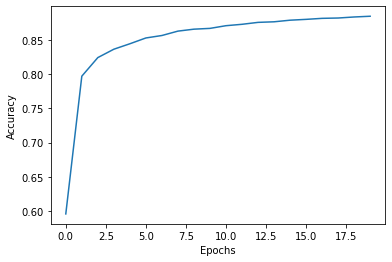

In [25]:
epoch_list = np.arange(0, classifnet.history.params['epochs'])  # creates an array of x values for each epoch
accuracy_list = classifnet.history.history['accuracy']  # calls the accuracies from training the network above

#  Plot the data
plt.plot(epoch_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0.5, 1.0, 'Model Accuracy')

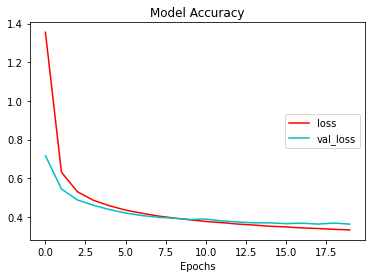

In [26]:
# create epochs vs. val_loss + loss graph
epoch_list = np.arange(0, classifnet.history.params['epochs'])

loss_list = classifnet.history.history['loss']
val_loss_list = classifnet.history.history['val_loss']

plt.plot(epoch_list, loss_list, 'r', val_loss_list, 'c')
plt.legend(('loss', 'val_loss'), loc='center right')
plt.xlabel('Epochs')
plt.title('Model Accuracy')

#### Classifier Performance Against Test Data

In [27]:
#  verify dimensionality before evaluating
print(reduced_test_pats.shape)
print(test_labels_class.shape)

#  see how the network does against test data
classifnet.evaluate(reduced_test_pats, test_labels_class)

(10000, 175)
(10000, 10)
313/313 [==============================] - 2s 6ms/step - loss: 0.3991 - accuracy: 0.8595 - mse: 0.0203


[0.3990612328052521, 0.8595000505447388, 0.020307179540395737]

Classification network performs slightly worse on test data compared to training data as expected.

### Convolutional Network Creation

In [28]:
print('Test images shape:', test_images.shape)
print('Train images shape:', train_images.shape)

Test images shape: (10000, 28, 28)
Train images shape: (60000, 28, 28)


In [29]:
nout = train_labels_class.shape[1]
hidden = 18
cnn_epochs = 6

cnn	= models.Sequential()	
cnn.add(layers.Conv2D(16,	(3, 3),	padding = 'same', activation = 'relu',	input_shape = (szx, szy, 1)))	
#cnn.add(layers.MaxPooling2D((2, 2)))	
cnn.add(layers.Conv2D(16,	(3, 3),	activation = 'relu'))	
#cnn.add(layers.MaxPooling2D((2, 2)))	
cnn.add(layers.Flatten())	
cnn.add(layers.Dense(hidden, activation = 'relu'))	
cnn.add(layers.Dense(nout, activation='softmax'))	

# display summary of network
print(cnn.summary())
print()
for layer in cnn.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()
    
#  compile the network with adam optimizer
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy', 'mse'])	
  
#  fit the network with training data
history	=	cnn.fit(train_images,
                  train_labels_class,
                  validation_split = 0.1,
                  epochs = cnn_epochs,
                  batch_size = 64,
                  verbose = True,)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense_6 (Dense)             (None, 18)                194706    
                                                                 
 dense_7 (Dense)             (None, 10)                190       
                                                                 
Total params: 197,376
Trainable params: 197,376
Non-trainable params: 0
_________________________________________________________________
None

layer name : conv2d | input shape : (None,

2022-11-20 21:17:16.882044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


844/844 [==============================] - ETA: 0s - loss: 1.1406 - accuracy: 0.6527 - mse: 0.0446

2022-11-20 21:17:25.423669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


844/844 [==============================] - 9s 11ms/step - loss: 1.1406 - accuracy: 0.6527 - mse: 0.0446 - val_loss: 0.5217 - val_accuracy: 0.8283 - val_mse: 0.0249
Epoch 2/6
844/844 [==============================] - 9s 10ms/step - loss: 0.4229 - accuracy: 0.8616 - mse: 0.0200 - val_loss: 0.3920 - val_accuracy: 0.8658 - val_mse: 0.0190
Epoch 3/6
844/844 [==============================] - 9s 11ms/step - loss: 0.3120 - accuracy: 0.8929 - mse: 0.0154 - val_loss: 0.3629 - val_accuracy: 0.8760 - val_mse: 0.0181
Epoch 4/6
844/844 [==============================] - 9s 11ms/step - loss: 0.2599 - accuracy: 0.9084 - mse: 0.0132 - val_loss: 0.3759 - val_accuracy: 0.8843 - val_mse: 0.0174
Epoch 5/6
844/844 [==============================] - 9s 11ms/step - loss: 0.2275 - accuracy: 0.9199 - mse: 0.0116 - val_loss: 0.3674 - val_accuracy: 0.8828 - val_mse: 0.0172
Epoch 6/6
844/844 [==============================] - 9s 11ms/step - loss: 0.2018 - accuracy: 0.9278 - mse: 0.0104 - val_loss: 0.3530 - val_a

##### CNN Graphs

Text(0.5, 1.0, 'Accuracy')

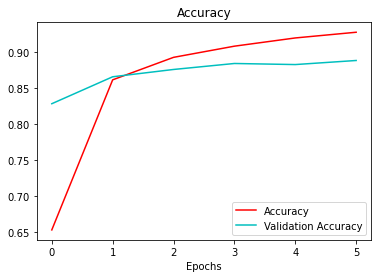

In [30]:
epoch_list = np.arange(0, cnn.history.params['epochs'])  # creates an array of x values for each epoch
accuracy_list = cnn.history.history['accuracy'] # calls the accuracies from training the network above
val_list = cnn.history.history['val_accuracy']  

#  Plot the data
plt.plot(epoch_list, accuracy_list, 'r', val_list, 'c')
plt.legend(('Accuracy', 'Validation Accuracy'), loc = 'lower right')
plt.xlabel('Epochs')
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

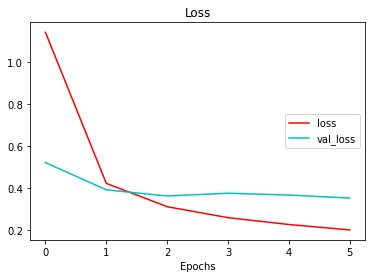

In [31]:
# create epochs vs. val_loss + loss graph
epoch_list = np.arange(0, cnn.history.params['epochs'])

loss_list = cnn.history.history['loss']
val_loss_list = cnn.history.history['val_loss']

plt.plot(epoch_list, loss_list, 'r', val_loss_list, 'c')
plt.legend(('loss', 'val_loss'), loc='center right')
plt.xlabel('Epochs')
plt.title('Loss')

##### Architecture Analysis

Relu and sigmoid activation's both did not change the overall accuracy of the network. Sigmoid took noticeably longer to compile without increasing accuracy. All else equal, they both produced an overally accuracy of roughly 87%. I am sticking with softmax for this classification, as justified above in the previous problem.

Additionally, increasing batch size with a constant number of epochs led to a decrease in overall accuracy. The accuracy never hit its horizontal asympotote and the network took longer to train. As a result, I decreased my batch size by half, from 126 to 63. This increased my accuracy from the high 80s to low 90s.

Increasing epochs above about 6 takes substancially longer to compile without a great increase in overally accuracy. Most of the learning is done in the first 6 epochs. Additionally, more epochs increases the chances of overfitting in this strong network.

One of the greatest increases in accuracy I witnessed was changing the (2, 2) part of the CNN to (1, 1). By decreasing the downsampling further, the accuracy rose to 95% all else equal. Changing the downsampling to (1, 1) is equivalent to removing it entirely, which in this case, works well. However, removing downsampling greatly increased my evidence of overfitting. This is because the network is no reducing the dimensionality of the images, making overfitting more likely for the same number of epochs (at least that's my best guess for an explaination).

At this point I began to notice signs of overfitting. So I turned to adjusting the number of hidden units to attempt to fix it.

For the number of hidden units, I began with 30. , the model I then tried increasing the number of epochs to 60, but the network definitely started to show signs of overfitting. Validation accuracy decreased, and validation loss increased while training loss decreased. I reduced the number of hidden units back to 30. It is important to note that the below graphs show signs of the network in a "pre-overfitting" stage. Notice that the while validation loss and loss diverage, validation accuracy does not begin decreasing. Perhaps if I were to increase the number of hidden units or increase the number of epochs, the model would begin to enter a stage of overfitting. Just to double check, I decreased the number of hidden units to 15. The model hit an accuracy of 87%, but did not show signs of overfitting whatsoever. Maybe I just needed to find a happy medium between 15 and 30, balancing accuracy and overfitting. 18 hidden units did the job well, balancing 92% accuracy with limited signs of overfitting. Validation loss and loss began diverging, but validating accuracy never began to decreasing.

In [32]:
#  evaluate the network against the test images

cnn.evaluate(test_images, test_labels_class)	

313/313 [==============================] - 2s 7ms/step - loss: 0.4157 - accuracy: 0.8781 - mse: 0.0180


[0.4157339930534363, 0.8781000375747681, 0.017960090190172195]

As expected, the network did slightly worse against the testing images. However, the accuracy is still high -- the network did simply "get lucky" in classifying these images.